# Instalação das bibiliotecas

In [ ]:
# !pip install transformers
# !pip install keras
# !pip install tensorflow
# !pip install seqeval
# !pip install pandas

In [ ]:
import torch
import numpy as np
import pandas as pd
import re
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer
from keras.utils import pad_sequences
import seqeval
from seqeval.metrics import accuracy_score, classification_report
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import Dropout
from transformers import get_linear_schedule_with_warmup

# Limpeza do conll
Limpando as posiçoes do formato conll, vindo do label studio

In [ ]:
def clean_conll(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    lines.pop(0)
    new_lines = []
    for line in lines:
        new_line = line.replace('-X- _', '')
        new_lines.append(new_line)
    with open(path, 'w') as f:
        f.writelines(new_lines)


In [ ]:
clean_conll('data.conll')

# Convertendo o conll para IOB
Convertendo o conll, agora sem a coluna de posições, para a o formato IOB (Inside–outside–beginning) padrão no estudo de NER.

In [ ]:
def conll_to_iob(conll_file_path, iob_file_path):
    with open(conll_file_path, 'r') as conll_file:
        sentence = []
        sentences = []
        for line in conll_file:
            if line == '\n':
                sentences.append(sentence)
                sentence = []
            else:
                word, tag = line.split()
                sentence.append((word, tag))
        if sentence:
            sentences.append(sentence)

    iob_sentences = []
    for sentence in sentences:
        iob_sentence = []
        for i in range(len(sentence)):
            word, tag = sentence[i]
            iob_sentence.append((word, tag))
        iob_sentences.append(iob_sentence)

    data = []
    for i in range(len(iob_sentences)):
        for j in range(len(iob_sentences[i])):
            word, tag = iob_sentences[i][j]
            data.append(('Sentence: ' + str(i+1), word, tag))

    df = pd.DataFrame(data, columns=['Sentence #', 'Token', 'Tag'])
    df.to_csv(iob_file_path, index=False)



In [ ]:
conll_to_iob('data.conll','data.csv')

# Embaralhando os dados
Devido ao fato de termos pegado tweets com datas parecidas, é interessandte embaralhar esse dados para obtermos um conjunto diverso.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from random import randint
random_number = 11 #apo
print(random_number)
def read_and_shuffle(file_path):
    df = pd.read_csv(file_path)
    df['Index'] = df.index
    df['Group'] = df['Sentence #'].str.extract(r':\s*(\d+)').astype(int)
    original_order = df['Group'].unique()
    shuffled_order = shuffle(original_order, random_state=random_number)
    group_mapping = dict(zip(original_order, shuffled_order))
    df['Group'] = df['Group'].map(group_mapping)
    df = df.sort_values(['Group', 'Index'])
    df = df.drop(['Group', 'Index'], axis=1)
    return df


11


In [ ]:
data_shuffled = read_and_shuffle(file_path='data.csv')

In [ ]:
data_shuffled

,Sentence #,Token,Tag
30288,Sentence: 1007,"""",O
30289,Sentence: 1007,Estou,O
30290,Sentence: 1007,convencido,O
30291,Sentence: 1007,que,O
30292,Sentence: 1007,o,O
...,...,...,...
26280,Sentence: 881,",",O
26281,Sentence: 881,não,O
26282,Sentence: 881,surpreendeu.,B-pos
26283,Sentence: 881,Abs,O


# Dividindo em test, dev e val

In [ ]:
def split(df):
    unique_sentences = df['Sentence #'].unique()

    total_sentences = len(unique_sentences)
    train_size = int(0.7 * total_sentences)
    dev_size = int(0.2 * total_sentences)
    test_size = total_sentences - train_size - dev_size

    train_sentences = unique_sentences[:train_size]
    dev_sentences = unique_sentences[train_size:train_size + dev_size]
    test_sentences = unique_sentences[train_size + dev_size:]

    train_data = df[df['Sentence #'].isin(train_sentences)]
    dev_data = df[df['Sentence #'].isin(dev_sentences)]
    test_data = df[df['Sentence #'].isin(test_sentences)]

    train_data.to_csv('train.csv', index=False)
    dev_data.to_csv('dev.csv', index=False)
    test_data.to_csv('test.csv', index=False)


In [ ]:
split(data_shuffled)

# Carregando os dados e embaralhando eles

In [ ]:
train = read_and_shuffle("train.csv")
print(len(train))
train.tail()

24709


,Sentence #,Token,Tag
24558,Sentence: 567,para,O
24559,Sentence: 567,o,O
24560,Sentence: 567,rival,O
24561,Sentence: 567,mais,O
24562,Sentence: 567,próximo,O


In [ ]:
dev = read_and_shuffle("dev.csv")
print(len(dev))
dev.tail()

7099


,Sentence #,Token,Tag
0,Sentence: 470,eu,O
1,Sentence: 470,amei,B-pos
2,Sentence: 470,esse,O
3,Sentence: 470,jornalista,O
4,Sentence: 470,kkkkk,O


In [ ]:
test = read_and_shuffle("test.csv")
print(len(test))
test.tail()

3613


,Sentence #,Token,Tag
699,Sentence: 933,fazem,O
700,Sentence: 933,são,O
701,Sentence: 933,parcerias,O
702,Sentence: 933,público-privadas,O
703,Sentence: 933,.,O


# Limpando os tweets
Infelizmente o label studio não consegue processar links e emojis. Então removemos essas informações afim de focar nas palavras.

In [1]:
def clean_tweet(tweet):
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = tweet.encode('ascii', 'ignore').decode('ascii')
    tweet = re.sub(r'http\S+|www\S+|https://|t\.co\S+', '', tweet)
    
    return tweet


In [ ]:
train['Token'] = [clean_tweet(tweet) if not pd.isnull(tweet) else np.nan for tweet in train['Token']]
dev['Token'] = [clean_tweet(tweet) if not pd.isnull(tweet) else np.nan for tweet in dev['Token']]
test['Token'] = [clean_tweet(tweet) if not pd.isnull(tweet) else np.nan for tweet in test['Token']]

In [ ]:
def remove_empty_tokens(df):
    empty_rows = df[df.isnull().any(axis=1) | (df['Token'] == '')]
    df = df.drop(empty_rows.index)
    return df

In [ ]:
train = remove_empty_tokens(train)
dev = remove_empty_tokens(dev)
test = remove_empty_tokens(test)


# Associando o token a sua classificação

In [ ]:
class ProcessSentences(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Token"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        print(self.grouped)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
sentences_data_train = ProcessSentences(train)
sentences_data_dev = ProcessSentences(dev)
sentences_data_test = ProcessSentences(test)

Sentence #
Sentence: 1                                    [(voto, O), (13, O)]
Sentence: 10      [(eu, O), (te, O), (amo, B-pos), (tiranogatore...
Sentence: 1000    [(adoro, B-pos), (quando, O), (a, O), (pessoa,...
Sentence: 1001    [(ATENO, O), (BOLSONARISTAS, O), (Vem, O), (ve...
Sentence: 1002    [(Min, O), (da, O), (Defesa, O), (pede, O), (a...
                                        ...                        
Sentence: 992     [(sinto, O), (falta, B-neg), (de, O), (um, O),...
Sentence: 993     [(desculpa, O), (turma, O), (vou, O), (ter, O)...
Sentence: 994     [(O, O), (esforo, O), (do, O), (nosso, O), (ti...
Sentence: 998     [(NaFonLeon, O), (Kamizeon, O), (Ele, O), (no,...
Sentence: 999     [(Sempre, O), (mantive, O), (minha, O), (vida,...
Length: 814, dtype: object
Sentence #
Sentence: 1004    [(o, O), (HORROR, B-neg), (que, O), (eh, O), (...
Sentence: 1005    [(Ns, O), (no, B-neg), (podemos, O), (ficar, O...
Sentence: 1010    [(Eu, O), (acho, O), (que, O), (preciso, O), (...

In [ ]:
sentences_train = [[word[0] for word in sentence] for sentence in sentences_data_train.sentences]
sentences_dev = [[word[0] for word in sentence] for sentence in sentences_data_dev.sentences]
sentences_test = [[word[0] for word in sentence] for sentence in sentences_data_test.sentences]


In [ ]:
labels_train = [[s[1] for s in sentence] for sentence in sentences_data_train.sentences]
labels_dev = [[s[1] for s in sentence] for sentence in sentences_data_dev.sentences]
labels_test = [[s[1] for s in sentence] for sentence in sentences_data_test.sentences]

In [ ]:
tag_values = list(set(train["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [ ]:
tag_values

['B-neg', 'I-neg', 'B-pos', 'O', 'I-pos', 'PAD']

# Definindo o device que irá ser usado durante o treinamento

In [ ]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Definindo o maior tamanho de uma sentença e o batch size

In [ ]:
MAX_LEN = 280
bs = 4

# Importando o BERTimbau e processando as palavras

In [ ]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)

In [ ]:
def tokenize_and_keep_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        tokenized_word = tokenizer.tokenize(str(word))
        n_subwords = len(tokenized_word)

        tokenized_sentence.extend(tokenized_word)

        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
tokenized_texts_and_labels_train = [
    tokenize_and_keep_labels(sent, labs)
    for sent, labs in zip(sentences_train, labels_train)
]

In [ ]:
tokenized_texts_and_labels_dev = [
    tokenize_and_keep_labels(sent, labs)
    for sent, labs in zip(sentences_dev, labels_dev)
]

In [ ]:
tokenized_texts_and_labels_test = [
    tokenize_and_keep_labels(sent, labs)
    for sent, labs in zip(sentences_test, labels_test)
]

In [ ]:
tokenized_texts_train = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_train]
labels_train = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_train]

tokenized_texts_dev = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_dev]
labels_dev = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_dev]

tokenized_texts_test = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_test]
labels_test = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_test]

In [ ]:
input_ids_train = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_train],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

input_ids_dev = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_dev],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

input_ids_test = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_test],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [ ]:
tags_train = pad_sequences([[tag2idx.get(l, tag2idx["PAD"]) for l in lab] for lab in labels_train],
                         maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                         dtype="long", truncating="post")

tags_dev = pad_sequences([[tag2idx.get(l, tag2idx["PAD"]) for l in lab] for lab in labels_dev],
                         maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                         dtype="long", truncating="post")


tags_test = pad_sequences([[tag2idx.get(l, tag2idx["PAD"]) for l in lab] for lab in labels_test],
                         maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                         dtype="long", truncating="post")


In [ ]:
attention_masks_train = [[float(i != 0.0) for i in ii] for ii in input_ids_train]
attention_masks_dev = [[float(i != 0.0) for i in ii] for ii in input_ids_dev]
attention_masks_test = [[float(i != 0.0) for i in ii] for ii in input_ids_test]

In [ ]:
train_inputs = torch.tensor(input_ids_train)
dev_inputs = torch.tensor(input_ids_dev)
test_inputs = torch.tensor(input_ids_test)
train_tags = torch.tensor(tags_train)
dev_tags = torch.tensor(tags_dev)
test_tags = torch.tensor(tags_test)
train_masks = torch.tensor(attention_masks_train)
dev_masks = torch.tensor(attention_masks_dev)
test_masks = torch.tensor(attention_masks_test)

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

dev_data = TensorDataset(dev_inputs, dev_masks, dev_tags)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=bs)

test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=bs)

# Definindo o BERTimbau para a classificação por token

In [ ]:
from transformers import BertForTokenClassification 

In [ ]:
dropout_rate = 0.2

model = BertForTokenClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False,
     hidden_dropout_prob=dropout_rate
)


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model check

# Carregando o modelo na GPU

In [ ]:
model.cuda(1);

# Definindo parâmetros do treino e otimizador



In [ ]:
weight_decay_rate = 0.01
lr = 3e-5
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay': weight_decay_rate},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=lr, eps=1e-8)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

In [ ]:
#Ao fazer fine-tuning de modelos grandes, percebe-se que a conversão da loss, é feita rapidamente. Durante os nossos estudos, percebemos que a partir de 2 épocas acontecia over-fitting. Por isso estamos usando 2 épocas
epochs = 2
max_grad_norm = 1.0

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Treinamento do modelo


In [ ]:
#Guada-se o valor da loss de cada época para a apresentação do gráfico
loss_values, development_loss_values = [], []

for _ in range(epochs):

    model.train()
    #Resetando a loss total para cada época
    total_loss = 0

    for step, batch in enumerate(train_dataloader):

        #Colocando cada batch na GPU
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        #Removando os gradientes antigos antes de usar o backward
        model.zero_grad()
        
        #Pegando a loss para usar depois
        outputs = model(b_input_ids, token_type_ids=None,attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]

        #Calculando o gradiente dos pesos em relação a loss
        loss.backward()
        
        #Loss do treino
        total_loss += loss.item()

        #Limitação (clipping) da norma do gradiente
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        
        # Atualizando paramentros
        optimizer.step()

        #Atualizando a taxa de aprendizado
        scheduler.step(loss)

    #Calculo da loss média de acordo com os dados do treino
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))
    

    #Guardando cada valor da loss para a aparesentação do gráfico
    loss_values.append(avg_train_loss)

    #Avaliando a performance do modelo com os dados do development
    model.eval()
    #Resetando a loss do development para a época atual
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in dev_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        #Usando torch.no_grad() para economizar memoria e acelerar o treinamento
        with torch.no_grad():
            #Pegando outputs do modelo para calcular a loss depois
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
            
        #Jogando os outputs e as labels para a CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        #Calculando a precisão do batch atual nas frases do development
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(dev_dataloader)
    development_loss_values.append(eval_loss)
    print("Development loss: {}".format(eval_loss))
    pred_tags_filtered = [[tag_values[p_i]] for p, l in zip(predictions, true_labels)
                          for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    dev_tags_filtered = [[tag_values[l_i]] for l in true_labels
                        for l_i in l if tag_values[l_i] != "PAD"]

    print("Development Accuracy: {}".format(accuracy_score(pred_tags_filtered, dev_tags_filtered)))
    print("Development classification report:\n{}".format(classification_report(pred_tags_filtered, dev_tags_filtered, digits=4)))
    print()


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Average train loss: 0.1061737172068188
Development loss: 0.02793148018676659
Development Accuracy: 0.9238947957470621


/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Development classification report:
              precision    recall  f1-score   support

          AD     0.0000    0.0000    0.0000         1
         neg     0.6568    0.5551    0.6017       717
         pos     0.5955    0.6329    0.6136       207

   micro avg     0.6404    0.5719    0.6042       925
   macro avg     0.4174    0.3960    0.4051       925
weighted avg     0.6423    0.5719    0.6037       925


Average train loss: 0.029085757012259874
Development loss: 0.02472056425176561
Development Accuracy: 0.9397873531057639
Development classification report:
              precision    recall  f1-score   support

          AD     0.0000    0.0000    0.0000         1
         neg     0.6634    0.6667    0.6650       603
         pos     0.6773    0.6712    0.6742       222

   micro avg     0.6671    0.6671    0.6671       826
   macro avg     0.4469    0.4459    0.4464       826
weighted avg     0.6663    0.6671    0.6667       826




# Plot do gráfico da loss

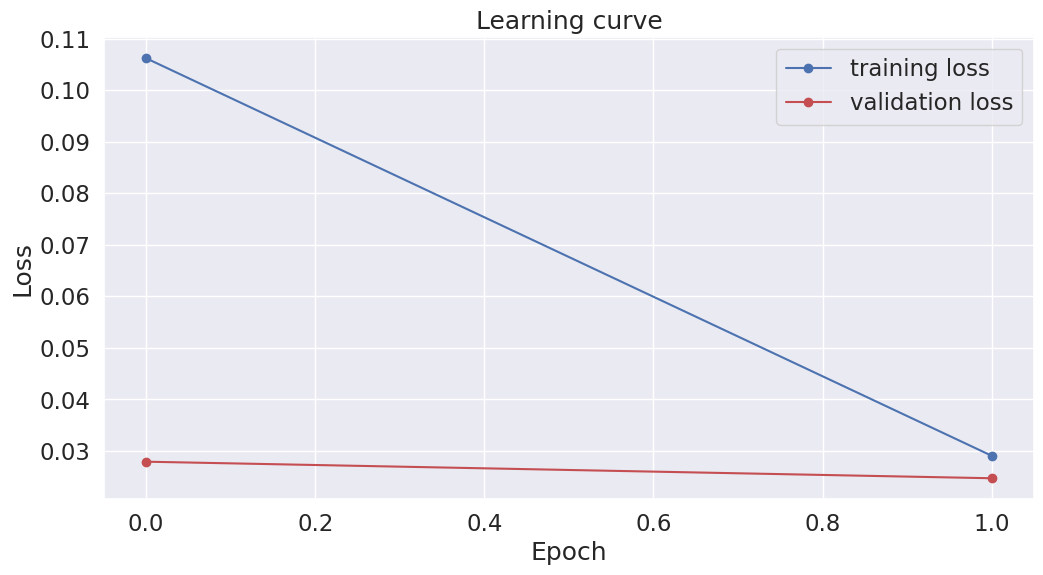

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(development_loss_values, 'r-o', label="validation loss")

plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Avaliação do modelo

In [ ]:
#Colocando o modelo no modo de avaliação
model.eval()
nb_eval_steps, nb_eval_examples = 0, 0
predictions , true_labels = [], []

input_ids_list = []

for batch in test_dataloader:

    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

        #Usando torch.no_grad() para economizar memoria e acelerar a avaliação
    with torch.no_grad():
          #Pegando outputs do modelo para calcular a loss depois
        outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
    #Jogando os outputs e as labels para a CPU
    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    input_ids_list.extend(b_input_ids)
    
    #Calculando a precisão do batch atual nas frases do test
    eval_loss += outputs[0].mean().item()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

pred_tags_filtered = [[tag_values[p_i]] for p, l in zip(predictions, true_labels)
                        for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
dev_tags_filtered = [[tag_values[l_i]] for l in true_labels
                    for l_i in l if tag_values[l_i] != "PAD"]
print(random_number)
print("Test Accuracy: {}".format(accuracy_score(pred_tags_filtered, dev_tags_filtered)))
print("Test classification report:\n{}".format(classification_report(pred_tags_filtered, dev_tags_filtered, digits=4)))
print()


11
Test Accuracy: 0.9521060508873209
Test classification report:
              precision    recall  f1-score   support

         neg     0.7552    0.7273    0.7410       297
         pos     0.7712    0.7564    0.7638       156

   micro avg     0.7608    0.7373    0.7489       453
   macro avg     0.7632    0.7418    0.7524       453
weighted avg     0.7608    0.7373    0.7488       453




# Salvando o modelo treinado

In [ ]:
torch.save(model.state_dict(), 'classifier.pth')

# Exemplo do modelo na prática

In [ ]:
test_sentence = "eu odeio e amo todo mundo"


In [ ]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda(1)


In [ ]:
input_ids

tensor([[  101,  2779,   146,   272,   247,   122, 14283,  1364,  1147,   102]],
       device='cuda:1')

In [ ]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)


In [ ]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)


In [ ]:
new_labels

['O', 'O', 'B-neg', 'O', 'B-pos', 'O', 'O', 'O']

In [ ]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))


O	[CLS]
O	eu
B-neg	odeio
O	e
B-pos	amo
O	todo
O	mundo
O	[SEP]
